In [62]:
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [63]:
# Check for GPU support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [64]:
# Define transformations for Fashion MNIST
trf = transforms.Compose([
    transforms.Grayscale(3),  # Convert grayscale to 3-channel to match ResNet input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.2860, 0.2860, 0.2860], std=[0.3530, 0.3530, 0.3530])  # Normalize pixel values
])


In [65]:
# Load Fashion MNIST dataset
train_dataset = datasets.FashionMNIST(root="./data", train=True, transform=trf, download=True)
test_dataset = datasets.FashionMNIST(root="./data", train=False, transform=trf, download=True)

In [66]:
# Create data loaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

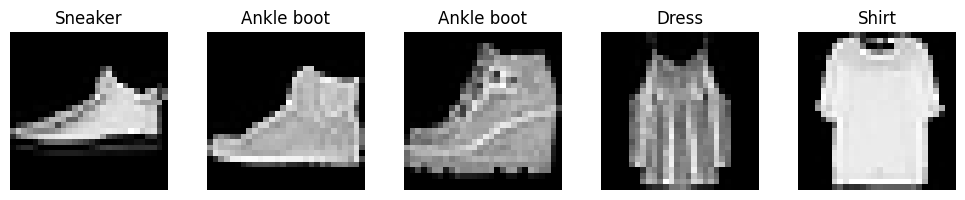

In [67]:
# print the images for refrence

import matplotlib.pyplot as plt

# Function to visualize n images from the train_loader
def show_images_from_train_loader(train_loader, n=5):
    """
    Displays n images from the train_loader with their labels.

    Args:
    train_loader (DataLoader): DataLoader for the training dataset.
    n (int): Number of images to display.
    """
    data_iter = iter(train_loader)
    images, labels = next(data_iter)  # Fetch a batch of images
    class_names = [
        "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
        "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
    ]

    plt.figure(figsize=(10, 2 * n // 5))
    for i in range(min(n, len(images))):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i][0], cmap='gray')
        plt.title(class_names[labels[i].item()])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example: Display 5 images from train_loader
show_images_from_train_loader(train_loader, n=5)



In [68]:
# Define the FashionModel
class FashionModel(nn.Module):
    def __init__(self,dropout_prob):
        super(FashionModel, self).__init__()

        # Load ResNet18 with pre-trained weights
        pretrain = models.resnet18(pretrained=True)

        # Freeze the convolutional layers
        for param in pretrain.parameters():
            param.requires_grad = False

        # Get the number of features from the final fully connected layer of ResNet18
        features = pretrain.fc.in_features

        # Modify the fully connected layer to have 4 layers
        pretrain.fc = nn.Sequential(
            nn.Linear(features, 256),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),  # Output layer for 10 classes (Fashion MNIST)
        )

        # Store the modified model
        self.modified_model = pretrain

    def forward(self, x):
        # Forward pass through the modified model
        return self.modified_model(x)


In [69]:
def train_test(model, epochs, train_loader, test_loader, optimizer, loss_fn):
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []

    for i in range(epochs):
        model.train()
        train_batch_loss = 0
        correct_train = 0
        total_train = 0
        for img, lbl in train_loader:
            img, lbl = img.to(device), lbl.to(device)
            # Zero gradients
            optimizer.zero_grad()
            # Forward pass
            y_pred = model(img)
            # Loss
            loss = loss_fn(y_pred, lbl)
            train_batch_loss += loss.item()
            # Accuracy
            total_train += lbl.shape[0]
            pred_lbl = torch.argmax(y_pred, dim=1)
            correct_train += (pred_lbl == lbl).sum().item()
            # Backpropagation
            loss.backward()
            # Update parameters
            optimizer.step()

        avg_train_loss = train_batch_loss / len(train_loader)
        batch_train_acc = correct_train / total_train*100
        train_loss.append(avg_train_loss)
        train_acc.append(batch_train_acc)

        # Testing phase
        model.eval()
        test_batch_loss = 0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for img, lbl in test_loader:
                img, lbl = img.to(device), lbl.to(device)
                # Forward pass
                y_pred = model(img)
                # Loss
                loss = loss_fn(y_pred, lbl)
                test_batch_loss += loss.item()
                # Accuracy
                total_test += lbl.shape[0]
                pred_lbl = torch.argmax(y_pred, dim=1)
                correct_test += (pred_lbl == lbl).sum().item()

        avg_test_loss = test_batch_loss / len(test_loader)
        batch_test_acc = correct_test / total_test*100
        test_loss.append(avg_test_loss)
        test_acc.append(batch_test_acc)
        print(f"Epoch: {i + 1}, Train Loss: {avg_train_loss:.4f}, Train Acc: {batch_train_acc:.4f}%, Test Loss: {avg_test_loss:.4f}, Test Acc: {batch_test_acc:.4f}%")


    return train_loss, test_loss, train_acc, test_acc


In [70]:
def plot(epochs, train_loss, test_loss, train_acc, test_acc):
    epoch_numbers = list(range(1, epochs + 1))  # Create a list of epoch numbers
    plt.figure(figsize=(12, 5))

    # Plot Losses
    plt.subplot(1, 2, 1)
    plt.plot(epoch_numbers, train_loss, label='Train Loss')
    plt.plot(epoch_numbers, test_loss, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epoch_numbers, train_acc, label='Train Acc')
    plt.plot(epoch_numbers, test_acc, label='Test Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1, Train Loss: 1.6723, Train Acc: 40.3083%, Test Loss: 0.9780, Test Acc: 65.0500%
Epoch: 2, Train Loss: 1.0176, Train Acc: 63.4400%, Test Loss: 0.8575, Test Acc: 69.3100%
Epoch: 3, Train Loss: 0.9378, Train Acc: 66.2900%, Test Loss: 0.7922, Test Acc: 72.0900%
Epoch: 4, Train Loss: 0.8866, Train Acc: 68.1967%, Test Loss: 0.7710, Test Acc: 72.5900%
Epoch: 5, Train Loss: 0.8526, Train Acc: 69.2117%, Test Loss: 0.7572, Test Acc: 73.4300%
Epoch: 6, Train Loss: 0.8351, Train Acc: 69.6667%, Test Loss: 0.7440, Test Acc: 73.0700%
Epoch: 7, Train Loss: 0.8239, Train Acc: 70.0833%, Test Loss: 0.7186, Test Acc: 74.4600%
Epoch: 8, Train Loss: 0.8036, Train Acc: 70.8100%, Test Loss: 0.7036, Test Acc: 74.6800%
Epoch: 9, Train Loss: 0.7997, Train Acc: 71.0767%, Test Loss: 0.6918, Test Acc: 74.9500%
Epoch: 10, Train Loss: 0.7881, Train Acc: 71.3567%, Test Loss: 0.6839, Test Acc: 75.4200%


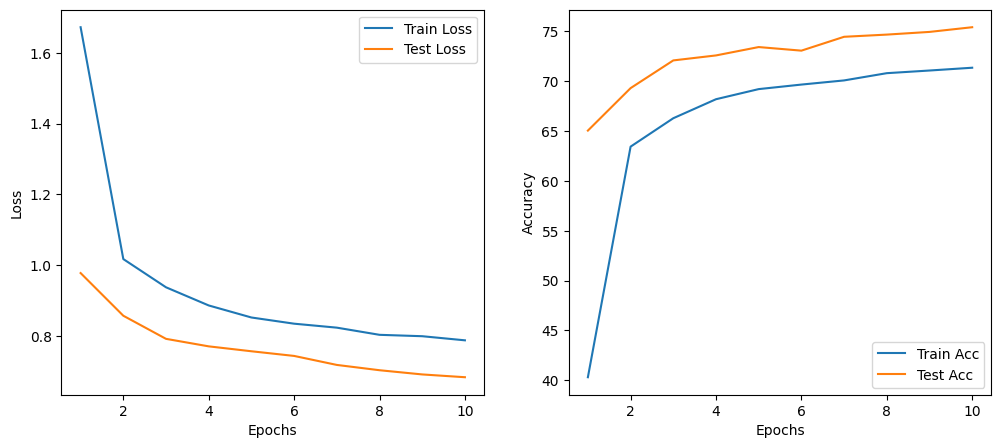

In [71]:
# Initialize model, optimizer, and loss function
model = FashionModel(dropout_prob=0.3).to(device)
lr = 0.009  # Lower learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()
epochs = 10

# Train and test the model
train_loss, test_loss, train_acc, test_acc = train_test(
    model, epochs, train_loader, test_loader, optimizer, loss_fn
)

# Plot the results
plot(epochs, train_loss, test_loss, train_acc, test_acc)
